# Manifold Alignment
## Team LeakSeek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2 as cv
import scipy.spatial as sp

### Constants

In [2]:
# File Paths
MANIFOLD_IMG_PATH = 'manifolds/manifold1.png'
MANIFOLD_REF_IMG_PATH = 'ref_manifolds/manifold1.png'

# Color Segmentation
COLOR_SEGMENTATION_NEIGHBORHOOD_SIZE = 10

### Read Manifold and Reference Manifold Images

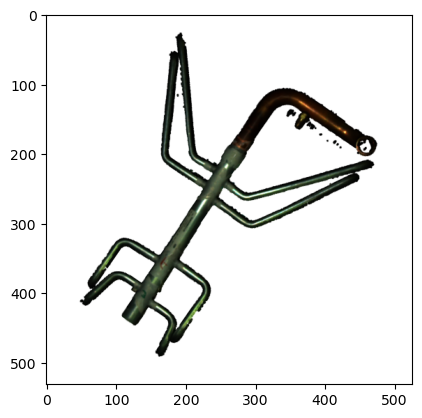

In [3]:
manifold_orig = cv.imread(MANIFOLD_IMG_PATH)
manifold_orig = cv.cvtColor(manifold_orig, cv.COLOR_BGR2RGB)
plt.imshow(manifold_orig)

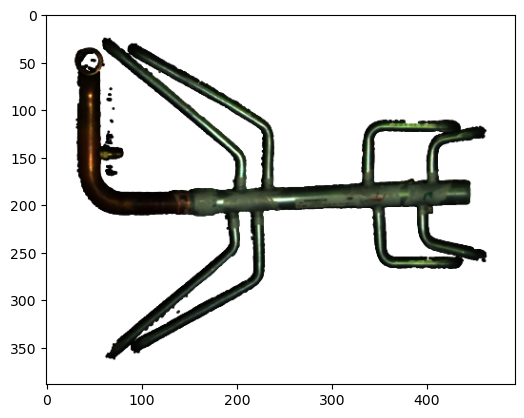

In [4]:
manifold_ref_orig = cv.imread(MANIFOLD_REF_IMG_PATH)
manifold_ref_orig = cv.cvtColor(manifold_ref_orig, cv.COLOR_BGR2RGB)
plt.imshow(manifold_ref_orig)

### Color Segmentation

In [5]:
def clean_color_segmentations(image):
    N_SIZE = COLOR_SEGMENTATION_NEIGHBORHOOD_SIZE

    output = image.copy()

    for x in range(len(image[0])):
        for y in range(len(image)):
            colorx = tuple(list(image[y][x]))
            if colorx == (255, 255, 255):
                continue

            # Record colors around current x, y pixel.
            colors = {}

            min_x = max(0, x-N_SIZE)
            max_x = min(len(image[0])-1, x+N_SIZE)
            min_y = max(0, y-N_SIZE)
            max_y = min(len(image)-1, y+N_SIZE)

            for x2 in range(min_x, max_x+1):
                for y2 in range(min_y, max_y+1):
                    colory = tuple(list(image[y2][x2]))
                    if colory == (255, 255, 255):
                        continue

                    color = str(image[y2, x2])
                    if colors.get(color) == None:
                        colors[color] = 1
                    else:
                        colors[color] += 1

            # Get most dominant color around this pixel.
            colors_sorted = sorted(colors.items(), key=lambda item: item[1], reverse=True)
            color = colors_sorted[0][0]
            color = color[1:len(color)-1]
            color = " ".join(color.split())
            color = color.split(' ')
            color = [int(x) for x in color]

            output[y, x] = color
            
        print('\r', 'Progress: {}%'.format(str(int(x / int(len(output[0])-1) * 100))), end='')

    return output
    
    
def convert_to_main_colors(image, main_colors):
    # Reference: https://sethsara.medium.com/change-pixel-colors-of-an-image-to-nearest-solid-color-with-python-and-opencv-33f7d6e6e20d
    output = image.copy()
    
    h, w, bpp = np.shape(output)

    # Change colors of each pixel
    for y in range(0,h):
        for x in range(0,w):
            color = tuple(list(output[y][x]))
            if color == (255, 255, 255):
                continue

            # Find nearest color
            input_color = (output[y][x][0], output[y][x][1], output[y][x][2])
            tree = sp.KDTree(main_colors) 
            ditsance, result = tree.query(input_color) 
            nearest_color = main_colors[result]

            output[y][x][0] = nearest_color[0]
            output[y][x][1] = nearest_color[1]
            output[y][x][2] = nearest_color[2]
    
    return output

In [6]:
manifold_color = manifold_orig.copy()
manifold_ref_color = manifold_ref_orig.copy()

In [7]:
main_colors = [(255,0,0), (0, 255, 0)] # TODO: Generalize this, automatically detect main colors?

 Progress: 100%

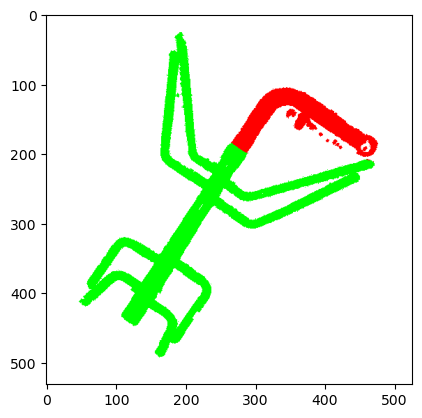

In [8]:
manifold_color = convert_to_main_colors(manifold_color, main_colors)
manifold_color = clean_color_segmentations(manifold_color)
plt.imshow(manifold_color)

 Progress: 100%

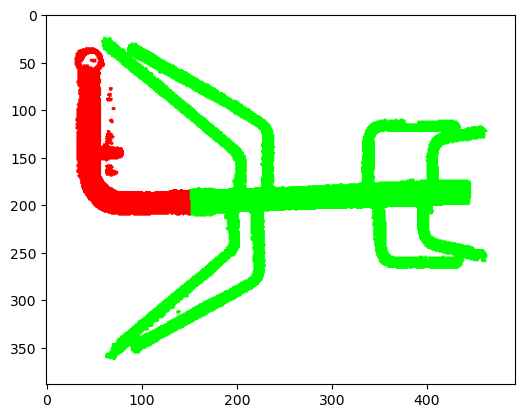

In [9]:
manifold_ref_color = convert_to_main_colors(manifold_ref_color, main_colors)
manifold_ref_color = clean_color_segmentations(manifold_ref_color)
plt.imshow(manifold_ref_color)

### Align Input Manifold Image to Reference Manifold Image

In [10]:
# Reference: https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
    return result

In [11]:
results = []
for deg in range(1, 361):
    print('\r', 'Progress: {}%'.format(str(int(deg / 360 * 100))), end='')
    
    manifold_rotated = rotate_image(manifold_color, deg)
    
    missed = 0
    for x in range(len(manifold_rotated[0])):
        for y in range(len(manifold_rotated)):
            color_rotated = tuple(manifold_rotated[y, x])
            color_ref = tuple(manifold_ref_color[y, x])
            if not (color_rotated == (0, 0, 0) or color_rotated == color_ref):
                missed += 1
    
    results.append((deg, missed))

best_deg = sorted(results, key=lambda x: x[1])[0][0]
best_deg

# TODO: Address the translation issue (input and reference manifolds are not aligned along the x and y axes).
# TODO: Address when the input and reference manifold images have different sizes, as the below error indicates.

 Progress: 0%

IndexError: index 389 is out of bounds for axis 0 with size 389

In [ ]:
manifold_rotated = rotate_image(manifold_color, best_deg)
plt.imshow(manifold_rotated)